# 使用 cv2.findContours 做 resize

1. 變換色階
2. 使用 cv2.findContours 做輪廓偵測
3. 定位裁切
4. cv2 Resize

In [1]:
import os
import cv2
import sys
import torch
import random
import numpy as np
from glob import glob
from torch.utils.data import Dataset
from scipy.ndimage.interpolation import zoom
from torchvision import transforms
import itertools
from scipy import ndimage
from torch.utils.data.sampler import Sampler
# import augmentations
# from augmentations.ctaugment import OPS
import matplotlib.pyplot as plt
from PIL import Image

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_26269/3443622460.py:9: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [2]:
image_path = '/home/u5169119/dataset/0_data_dataset_voc_950_kidney/JPEGImages/1000221_8_DATE20140630_STD02_SER01_IMG013.jpg'

In [3]:
image = cv2.imread(image_path)
src = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imgh,imgw = src.shape
threshold_value = 5  # 設置適當的閾值

gray = cv2.threshold(src, threshold_value, 255, cv2.THRESH_BINARY)[1]

gray shape:  (768, 1024)


Text(0.5, 1.0, 'Image')

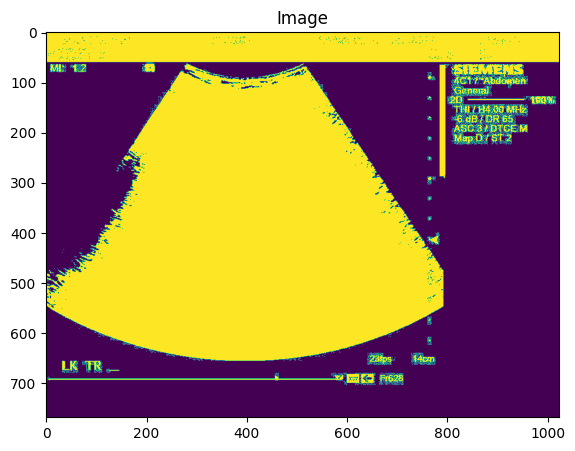

In [4]:
print("gray shape: ", gray.shape)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.imshow(gray)
plt.title("Image")

In [5]:
contours, hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [6]:
maxm=0
#fig = d2l.plt.imshow(src, cmap='gray')
for i in range(0, len(contours)):

    # cv2.boundingRect: 透過輪廓找到外接矩形
    # 輸出：(x, y)矩形左上角座標、w 矩形寬(x軸方向)、h 矩形高(y軸方向)
    x, y, w, h = cv2.boundingRect(contours[i])
    if w<imgw and h<imgh and w+h>maxm:
        maxm=w+h
        index=i
    # 在原影像上繪製出矩形
    '''fig.axes.add_patch(d2l.plt.Rectangle((x, y), w, h, fill=False,
                       linestyle="-", edgecolor=color,
                       linewidth=2))'''
x, y, w, h = cv2.boundingRect(contours[index])

In [7]:
print(x, y, w, h)

0 62 792 594


# 在原始圖上面框出

In [8]:
_image = image.copy()

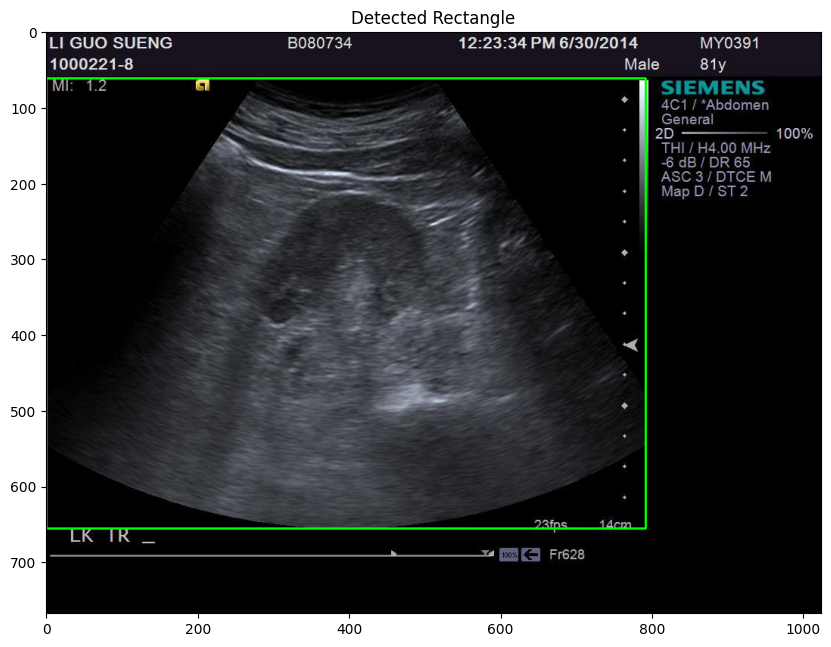

In [9]:
# 畫出最大矩形
if index != -1:
    x, y, w, h = cv2.boundingRect(contours[index])
    cv2.rectangle(_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# 顯示結果
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Rectangle")
plt.show()

# 直接裁切

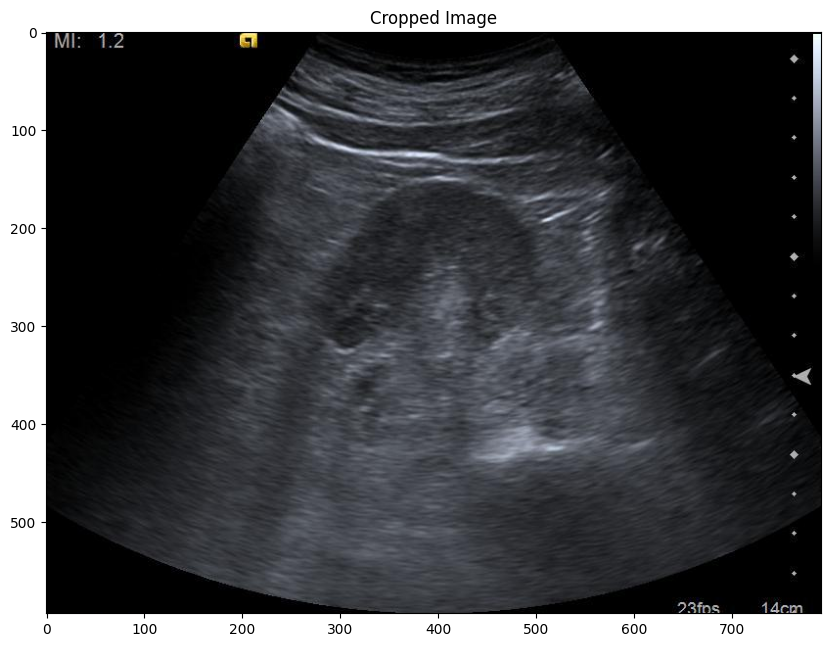

In [10]:
# 裁剪出最大矩形
if index != -1:
    x, y, w, h = cv2.boundingRect(contours[index])
    cropped_image = image[y:y + h, x:x + w]

    # 顯示裁剪出的區域
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Image")
    plt.show()
else:
    print("No valid contour found.")

# Resize

cropped_image.shape:  (594, 792, 3)
padded_image.shape:  (792, 792, 3)


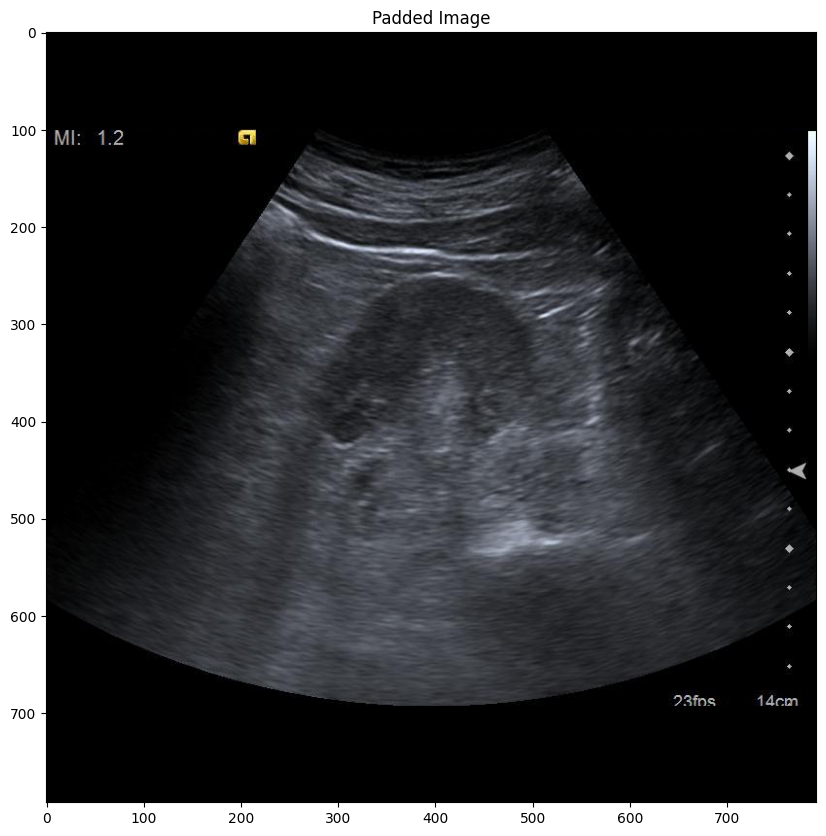

resize_image.shape:  (512, 512, 3)


In [11]:
print('cropped_image.shape: ', cropped_image.shape)

# 裁剪出最大矩形
if index != -1:
    x, y, w, h = cv2.boundingRect(contours[index])
    cropped_image = image[y:y + h, x:x + w]

    # 取得裁剪後圖像的尺寸
    crop_h, crop_w, _ = cropped_image.shape

    # 計算填充大小
    max_side = max(crop_h, crop_w)
    top = (max_side - crop_h) // 2
    bottom = max_side - crop_h - top
    left = (max_side - crop_w) // 2
    right = max_side - crop_w - left

    # 使用 cv2.copyMakeBorder 進行填充
    padded_image = cv2.copyMakeBorder(
        cropped_image, 
        top, bottom, left, right, 
        cv2.BORDER_CONSTANT, 
        value=[0, 0, 0]  # 填充顏色為黑色
    )
    
    print('padded_image.shape: ', padded_image.shape)
    # 顯示填充後的區域
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB))
    plt.title("Padded Image")
    plt.show()
else:
    print("No valid contour found.")
    
    
resize_image = cv2.resize(padded_image, (512, 512), interpolation=cv2.INTER_NEAREST)
print('resize_image.shape: ', resize_image.shape)

# 整合DataLoader

In [12]:
base_path = '/home/u5169119/PatchCL-MedSeg-jiyu'
dataset_path = '/home/u5169119/dataset/0_data_dataset_voc_950_kidney'
output_dir = base_path + '/dataset/splits/kidney'

supervised_loss_path = base_path + '/supervised pre training_loss.csv'
SSL_loss_path = base_path + '/SSL_loss.csv'

voc_mask_color_map = [
    [0, 0, 0], #_background
    [128, 0, 0] #kidney
]

In [13]:
import os
import sys
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import math
import time
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

sys.path.append(base_path)

from utils.transform import Transform
from utils.stochastic_approx import StochasticApprox
from utils.model import Network
# from utils.datasets_PASCAL_Crop import PascalVOCDataset
from utils.datasets_PASCAL_findContours import PascalVOCDataset
from utils.queues import Embedding_Queues
from utils.CELOSS import CE_loss
from utils.patch_utils import _get_patches
from utils.aug_utils import batch_augment
from utils.get_embds import get_embeddings
from utils.const_reg import consistency_cost
from utils.plg_loss import PCGJCL
from utils.torch_poly_lr_decay import PolynomialLRDecay
from utils.loss_file import save_loss

In [14]:
contrastive_batch_size = 64
img_size = 512
batch_size = 1
num_classes = 2
transform = Transform(img_size, num_classes)
embd_queues = Embedding_Queues(num_classes)
stochastic_approx = StochasticApprox(num_classes,0.5,0.8)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [15]:
labeled_dataset = PascalVOCDataset(txt_file=output_dir + "/1-3/labeled.txt", image_size=img_size, root_dir=dataset_path, labeled=True, colormap=voc_mask_color_map)
unlabeled_dataset = PascalVOCDataset(txt_file=output_dir + "/1-3/unlabeled.txt", image_size=img_size, root_dir=dataset_path, labeled=False, colormap=voc_mask_color_map)
val_dataset = PascalVOCDataset(txt_file=output_dir + "/val.txt", image_size=img_size, root_dir=dataset_path, labeled=True)

labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print('number of labeled_dataset: ', len(labeled_dataset))
print('number of unlabeled_dataset: ', len(unlabeled_dataset))
print('number of val_dataset: ', len(val_dataset))

number of labeled_dataset:  285
number of unlabeled_dataset:  570
number of val_dataset:  95


Image shape: torch.Size([1, 512, 512, 3]), Mask shape: torch.Size([1, 512, 512])


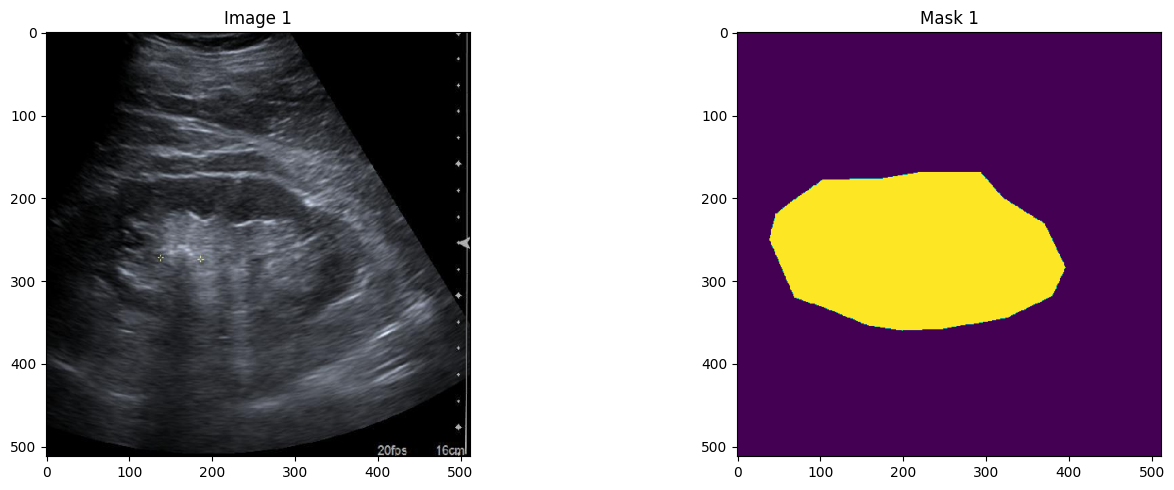

In [16]:
# 測試數據加載器
for images, masks in labeled_loader:
    # images.shape: 1, 3, X, Y
    # masks.shape: 1, X, Y    
    break 
print(f'Image shape: {images.shape}, Mask shape: {masks.shape}')

image_np = images[0].numpy().astype(int)
masks_np = masks[0].numpy().astype(int)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.imshow(image_np)
plt.title("Image 1")

plt.subplot(1, 2, 2)
plt.imshow(masks_np)
plt.title("Mask 1")
plt.tight_layout()
plt.show()

Channel 0 pixel counts: {0.0: 209317, 1.0: 52827}
Channel 1 pixel counts: {0.0: 52827, 1.0: 209317}
Original masks shape:  torch.Size([1, 512, 512])
Multi-channel masks shape:  torch.Size([1, 2, 512, 512])


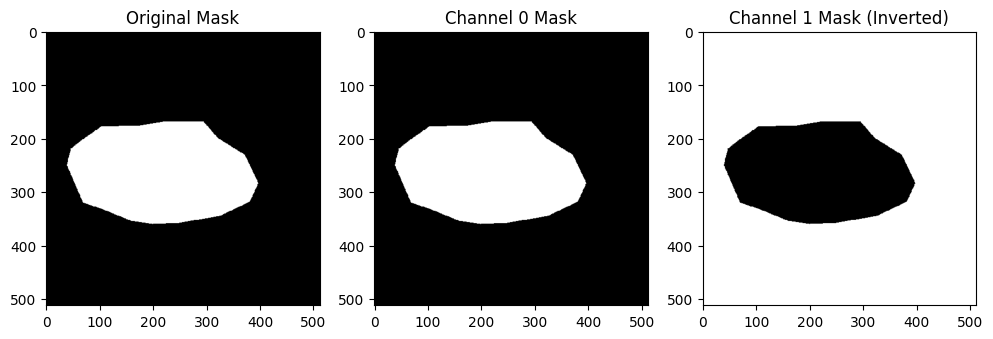

In [17]:
# 創建一個新的形狀為 [8, 2, 256, 256] 的張量
multi_channel_masks = torch.zeros((masks.size(0), 2, masks.size(1), masks.size(2)), dtype=torch.float32)

# 將單通道遮罩轉換為多通道遮罩
multi_channel_masks[:, 0, :, :] = masks.float()  # 原始遮罩
multi_channel_masks[:, 1, :, :] = 1 - masks.float()  # 反轉遮罩

# 檢查一個樣本中的唯一值和像素計數
imgs_np = multi_channel_masks[0, 0].numpy()
unique, counts = np.unique(imgs_np, return_counts=True)
pixel_counts = dict(zip(unique, counts))
print("Channel 0 pixel counts:", pixel_counts)

imgs_np = multi_channel_masks[0, 1].numpy()
unique, counts = np.unique(imgs_np, return_counts=True)
pixel_counts = dict(zip(unique, counts))
print("Channel 1 pixel counts:", pixel_counts)
print("Original masks shape: ", masks.shape)
print("Multi-channel masks shape: ", multi_channel_masks.shape)

# 顯示原圖和多通道遮罩
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(masks[0].numpy(), cmap='gray')
plt.title("Original Mask")
plt.subplot(1, 3, 2)
plt.imshow(multi_channel_masks[0, 0].numpy(), cmap='gray')
plt.title("Channel 0 Mask")
plt.subplot(1, 3, 3)
plt.imshow(multi_channel_masks[0, 1].numpy(), cmap='gray')
plt.title("Channel 1 Mask (Inverted)")
plt.show()